# AlphaZero 五子棋训练分析

本notebook对训练日志进行全面分析，提取关键信息并进行可视化，帮助理解训练过程和模型性能。

In [2]:
# 解析日志文件
log_path = '7x5_train_log_20250508_162100.txt'  # 请根据实际文件路径调整

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats
import os

# 设置可视化风格
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [4]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# 1. 检查并设置中文字体
def set_chinese_font():
    # 尝试使用系统自带的中文字体
    font_paths = [
        'C:/Windows/Fonts/simhei.ttf',  # 黑体
        'C:/Windows/Fonts/msyh.ttc',    # 微软雅黑
        'C:/Windows/Fonts/simkai.ttf',  # 楷体
        '/usr/share/fonts/truetype/wqy/wqy-microhei.ttc', # Linux微米黑
        '/System/Library/Fonts/PingFang.ttc' # macOS苹方
    ]
    
    # 查找第一个可用的中文字体
    for font_path in font_paths:
        if os.path.exists(font_path):
            font_prop = fm.FontProperties(fname=font_path)
            plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
            plt.rcParams['axes.unicode_minus'] = False
            return True
    
    # 如果没有找到系统字体，尝试使用已安装的字体
    fonts = ['SimHei', 'Microsoft YaHei', 'STSong', 'WenQuanYi Micro Hei', 'PingFang SC']
    for font in fonts:
        try:
            plt.rcParams['font.sans-serif'] = [font]
            plt.rcParams['axes.unicode_minus'] = False
            plt.plot([0, 1], [0, 1], label='测试')
            plt.legend()
            plt.close()
            return True
        except:
            continue
    
    # 如果没有找到系统字体，尝试下载并使用临时字体
    try:
        import urllib.request
        print("正在下载中文字体...")
        urllib.request.urlretrieve(
            "https://github.com/googlefonts/noto-cjk/raw/main/Sans/OTF/SimplifiedChinese/NotoSansCJKsc-Regular.otf",
            "NotoSansCJKsc-Regular.otf")
        font_prop = fm.FontProperties(fname="NotoSansCJKsc-Regular.otf")
        plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
        plt.rcParams['axes.unicode_minus'] = False
        return True
    except:
        print("无法自动下载中文字体，请手动安装")
        return False

# 设置中文字体
set_chinese_font()

True

## 1. 日志数据解析

从训练日志中提取两类关键信息：
1. 每批次训练详情（损失、KL散度等）
2. 定期评估结果（胜率等）

In [5]:
def parse_training_log(log_path):
    """解析训练日志文件，提取训练数据和评估数据"""
    
    # 初始化用于存储提取数据的列表
    train_data = []
    eval_data = []
    
    # 解析的正则表达式模式
    # 训练批次和对局信息匹配
    batch_pattern = re.compile(r'\[.*?\] INFO: 训练批次: (\d+)/(\d+) \| 对局长度: ([\d.]+) \| 数据点: (\d+) \| 总数据: (\d+)')
    
    # 训练步骤指标匹配
    metrics_pattern = re.compile(r'\[.*?\] INFO: 训练步骤 \| kl:([\d.]+) \| lr_mul:([\d.]+) \| loss:([\d.]+) \| entropy:([\d.]+) \| explained_var: ([\d.-]+)->([\d.-]+)')
    
    # 评估开始匹配
    eval_batch_pattern = re.compile(r'\[.*?\] INFO: === 批次 (\d+) 开始评估 ===')
    
    # 评估结果匹配
    pure_mcts_pattern = re.compile(r'\[纯MCTS评估结果\]\s*\n- 对局数: (\d+)\s*\n- 胜/负/平: (\d+)/(\d+)/(\d+)\s*\n- 胜率: ([\d.]+)%')
    minimax_pattern = re.compile(r'\[Minimax评估结果\]\s*\n- 对局数: (\d+)\s*\n- 胜/负/平: (\d+)/(\d+)/(\d+)\s*\n- 胜率: ([\d.]+)%')
    minimax_ab_pattern = re.compile(r'\[MinimaxAB评估结果\]\s*\n- 对局数: (\d+)\s*\n- 胜/负/平: (\d+)/(\d+)/(\d+)\s*\n- 胜率: ([\d.]+)%')
    
    # 评估汇总匹配
    overall_eval_pattern = re.compile(r'\[.*?\] INFO: 总局数: (\d+) \| 总胜局: (\d+) \| 总胜率: ([\d.]+)%')
    
    # 当前正在处理的数据
    current_batch = None
    current_total_batches = None
    current_episode_len = None
    current_data_points = None
    current_total_data = None
    eval_batch = None
    
    # 临时存储评估数据
    current_eval_data = {}
    
    # 读取整个日志文件为字符串
    with open(log_path, 'r', encoding='utf-8') as f:
        log_text = f.read()
    
    # 逐行处理
    lines = log_text.split('\n')
    i = 0
    while i < len(lines):
        line = lines[i]
        
        # 匹配训练批次和对局信息
        batch_match = batch_pattern.search(line)
        if batch_match:
            current_batch = int(batch_match.group(1))
            current_total_batches = int(batch_match.group(2))
            current_episode_len = float(batch_match.group(3))
            current_data_points = int(batch_match.group(4))
            current_total_data = int(batch_match.group(5))
            i += 1
            continue
        
        # 匹配训练指标数据
        metrics_match = metrics_pattern.search(line)
        if metrics_match and current_batch is not None:
            kl = float(metrics_match.group(1))
            lr_mult = float(metrics_match.group(2))
            loss = float(metrics_match.group(3))
            entropy = float(metrics_match.group(4))
            exp_var_old = float(metrics_match.group(5))
            exp_var_new = float(metrics_match.group(6))
            
            train_data.append({
                'batch': current_batch,
                'total_batches': current_total_batches,
                'episode_len': current_episode_len,
                'data_points': current_data_points,
                'total_data': current_total_data,
                'kl': kl,
                'lr_multiplier': lr_mult,
                'loss': loss,
                'entropy': entropy,
                'explained_var_old': exp_var_old,
                'explained_var_new': exp_var_new
            })
            
            # 重置当前批次信息
            current_batch = None
            current_total_batches = None
            current_episode_len = None
            current_data_points = None
            current_total_data = None
            i += 1
            continue
        
        # 匹配评估批次
        eval_batch_match = eval_batch_pattern.search(line)
        if eval_batch_match:
            eval_batch = int(eval_batch_match.group(1))
            current_eval_data = {'eval_batch': eval_batch}
            i += 1
            continue
        
        # 匹配纯MCTS评估结果
        # 这需要检查多行，组合成一个字符串再匹配
        if i+4 < len(lines) and '[纯MCTS评估结果]' in line and eval_batch is not None:
            multi_line = '\n'.join(lines[i:i+5])
            pure_mcts_match = pure_mcts_pattern.search(multi_line)
            if pure_mcts_match:
                games = int(pure_mcts_match.group(1))
                wins = int(pure_mcts_match.group(2))
                losses = int(pure_mcts_match.group(3))
                draws = int(pure_mcts_match.group(4))
                win_ratio = float(pure_mcts_match.group(5)) / 100  # 转换为小数
                
                current_eval_data['pure_mcts_games'] = games
                current_eval_data['pure_mcts_wins'] = wins
                current_eval_data['pure_mcts_losses'] = losses
                current_eval_data['pure_mcts_draws'] = draws
                current_eval_data['pure_mcts_win_ratio'] = win_ratio
                i += 5
                continue
        
        # 匹配Minimax评估结果
        if i+4 < len(lines) and '[Minimax评估结果]' in line and eval_batch is not None:
            multi_line = '\n'.join(lines[i:i+5])
            minimax_match = minimax_pattern.search(multi_line)
            if minimax_match:
                games = int(minimax_match.group(1))
                wins = int(minimax_match.group(2))
                losses = int(minimax_match.group(3))
                draws = int(minimax_match.group(4))
                win_ratio = float(minimax_match.group(5)) / 100  # 转换为小数
                
                current_eval_data['minimax_games'] = games
                current_eval_data['minimax_wins'] = wins
                current_eval_data['minimax_losses'] = losses
                current_eval_data['minimax_draws'] = draws
                current_eval_data['minimax_win_ratio'] = win_ratio
                i += 5
                continue
        
        # 匹配MinimaxAB评估结果
        if i+4 < len(lines) and '[MinimaxAB评估结果]' in line and eval_batch is not None:
            multi_line = '\n'.join(lines[i:i+5])
            minimax_ab_match = minimax_ab_pattern.search(multi_line)
            if minimax_ab_match:
                games = int(minimax_ab_match.group(1))
                wins = int(minimax_ab_match.group(2))
                losses = int(minimax_ab_match.group(3))
                draws = int(minimax_ab_match.group(4))
                win_ratio = float(minimax_ab_match.group(5)) / 100  # 转换为小数
                
                current_eval_data['minimax_ab_games'] = games
                current_eval_data['minimax_ab_wins'] = wins
                current_eval_data['minimax_ab_losses'] = losses
                current_eval_data['minimax_ab_draws'] = draws
                current_eval_data['minimax_ab_win_ratio'] = win_ratio
                i += 5
                continue
        
        # 匹配综合评估结果
        overall_match = overall_eval_pattern.search(line)
        if overall_match and eval_batch is not None:
            total_games = int(overall_match.group(1))
            total_wins = int(overall_match.group(2))
            overall_win_ratio = float(overall_match.group(3)) / 100  # 转换为小数
            
            current_eval_data['total_games'] = total_games
            current_eval_data['total_wins'] = total_wins
            current_eval_data['win_ratio'] = overall_win_ratio  # 使用综合胜率作为主要胜率
            current_eval_data['overall_win_ratio'] = overall_win_ratio
            
            # 计算总损失和总平局
            total_losses = 0
            total_draws = 0
            
            # 计算损失 = 总局数 - 总胜利 - 总平局
            if 'pure_mcts_draws' in current_eval_data:
                total_draws += current_eval_data['pure_mcts_draws']
            if 'minimax_draws' in current_eval_data:
                total_draws += current_eval_data['minimax_draws']
            if 'minimax_ab_draws' in current_eval_data:
                total_draws += current_eval_data['minimax_ab_draws']
            
            total_losses = total_games - total_wins - total_draws
            
            current_eval_data['total_losses'] = total_losses
            current_eval_data['total_draws'] = total_draws
            
            # 添加到评估数据列表
            eval_data.append(current_eval_data)
            
            # 重置评估批次
            eval_batch = None
            current_eval_data = {}
            i += 1
            continue
        
        i += 1
    
    # 转换为DataFrame
    train_df = pd.DataFrame(train_data)
    eval_df = pd.DataFrame(eval_data)
    
    # 对于评估数据，添加wins, losses, draws列，以兼容原始代码
    if len(eval_df) > 0:
        eval_df['wins'] = eval_df['total_wins']
        eval_df['losses'] = eval_df['total_losses']
        eval_df['draws'] = eval_df['total_draws']
    
    return train_df, eval_df

# 解析日志文件
train_df, eval_df = parse_training_log(log_path)

# 保存为CSV文件以便未来使用
train_df.to_csv('training_metrics.csv', index=False)
eval_df.to_csv('evaluation_metrics.csv', index=False)

# 显示提取的训练数据样例
print(f"共提取 {len(train_df)} 条训练数据记录")
train_df.head()

共提取 417 条训练数据记录


,batch,total_batches,episode_len,data_points,total_data,kl,lr_multiplier,loss,entropy,explained_var_old,explained_var_new
0,2,1200,34.5,276,476,0.02545,1.0,4.5916,3.8818,-0.002,0.137
1,3,1200,26.5,212,688,0.01761,1.0,4.6590,3.8501,0.058,0.135
2,4,1200,27.8,222,910,0.01436,1.0,4.7026,3.8444,0.041,0.142
3,5,1200,23.5,188,1098,0.01013,1.0,4.6038,3.8581,0.122,0.214
4,6,1200,29.8,238,1336,0.01115,1.0,4.5770,3.8648,0.189,0.277


In [6]:
# 显示提取的评估数据
print(f"共提取 {len(eval_df)} 条评估数据记录")
eval_df.head()

共提取 8 条评估数据记录


,eval_batch,pure_mcts_games,pure_mcts_wins,pure_mcts_losses,pure_mcts_draws,pure_mcts_win_ratio,minimax_games,minimax_wins,minimax_losses,minimax_draws,...,minimax_ab_win_ratio,total_games,total_wins,win_ratio,overall_win_ratio,total_losses,total_draws,wins,losses,draws
0,50,50,31,17,2,0.62,10,0,10,0,...,0.0,70,31,0.4429,0.4429,37,2,31,37,2
1,100,50,36,10,4,0.72,10,0,10,0,...,0.0,70,36,0.5143,0.5143,27,7,36,27,7
2,150,50,36,14,0,0.72,10,0,10,0,...,0.0,70,36,0.5143,0.5143,34,0,36,34,0
3,200,50,37,12,1,0.74,10,0,10,0,...,0.0,70,37,0.5286,0.5286,32,1,37,32,1
4,250,50,40,10,0,0.80,10,0,10,0,...,0.0,70,40,0.5714,0.5714,30,0,40,30,0


## 2. 基本训练指标分析

分析训练过程中的关键指标变化趋势，包括损失、熵、KL散度等。

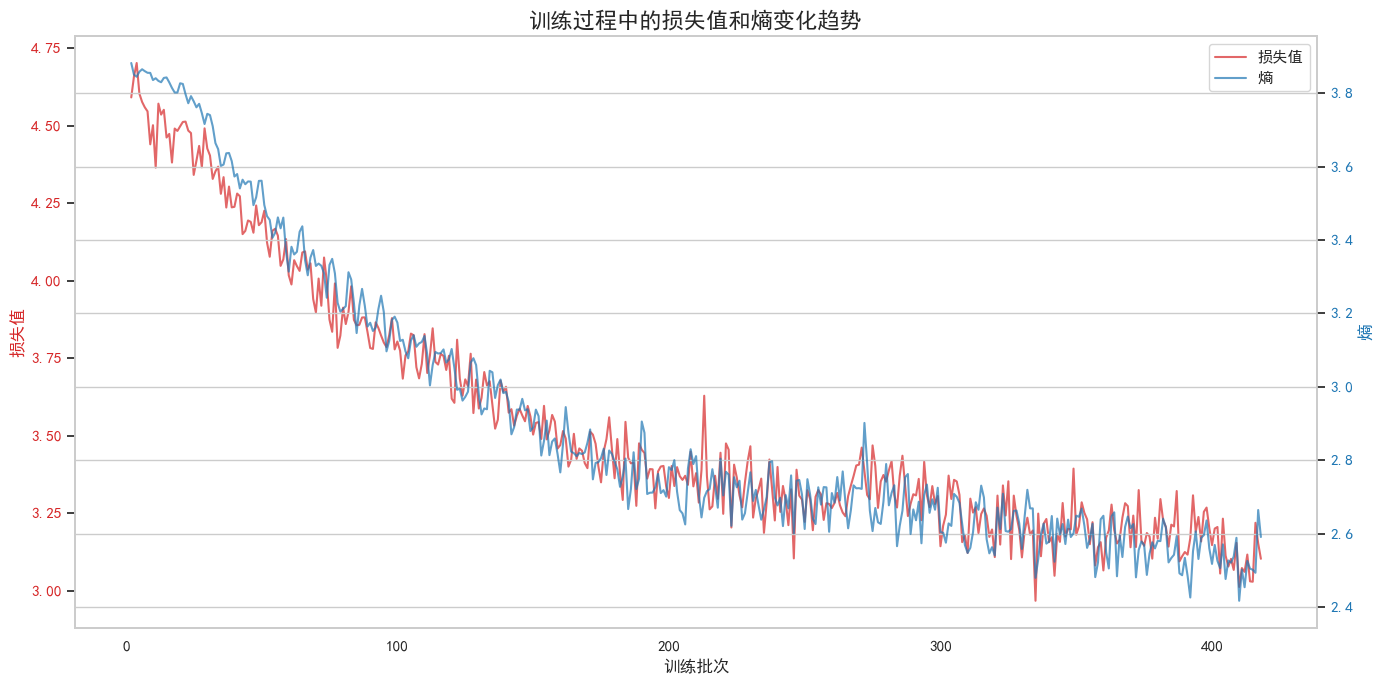

In [7]:
# 训练损失和熵趋势图
if 'loss' in train_df.columns and 'entropy' in train_df.columns and len(train_df) > 0:
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    color = 'tab:red'
    ax1.set_xlabel('训练批次')
    ax1.set_ylabel('损失值', color=color)
    ax1.plot(train_df['batch'], train_df['loss'], color=color, marker='', linestyle='-', alpha=0.7, label='损失值')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 创建第二个Y轴用于显示熵
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('熵', color=color)  
    ax2.plot(train_df['batch'], train_df['entropy'], color=color, marker='', linestyle='-', alpha=0.7, label='熵')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 添加网格线和标题
    ax1.grid(False)
    plt.title('训练过程中的损失值和熵变化趋势', fontsize=16)
    
    # 添加图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('loss_entropy_trend.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("训练数据不足，无法绘制损失和熵趋势图")

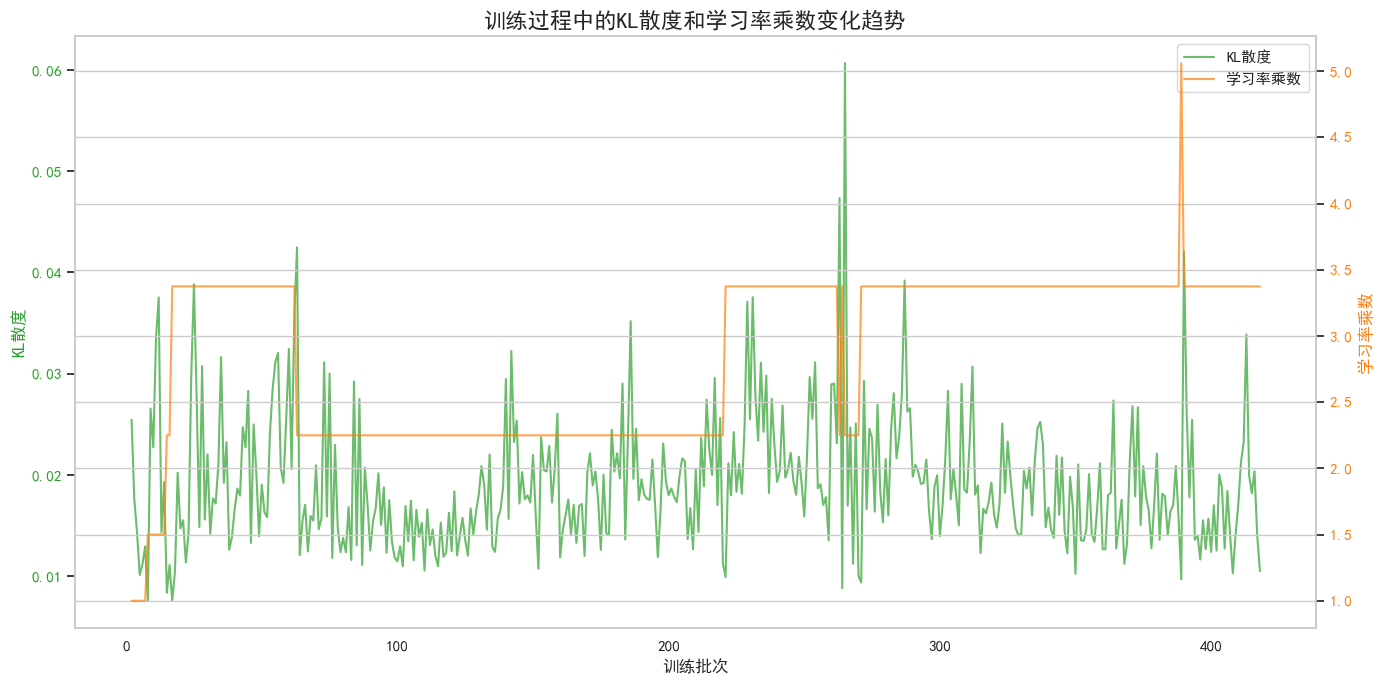

In [8]:
# KL散度和学习率乘数趋势图
if 'kl' in train_df.columns and 'lr_multiplier' in train_df.columns and len(train_df) > 0:
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    color = 'tab:green'
    ax1.set_xlabel('训练批次')
    ax1.set_ylabel('KL散度', color=color)
    ax1.plot(train_df['batch'], train_df['kl'], color=color, marker='', linestyle='-', alpha=0.7, label='KL散度')
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 创建第二个Y轴用于显示学习率乘数
    ax2 = ax1.twinx()  
    color = 'tab:orange'
    ax2.set_ylabel('学习率乘数', color=color)  
    ax2.plot(train_df['batch'], train_df['lr_multiplier'], color=color, marker='', linestyle='-', alpha=0.7, label='学习率乘数')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # 添加网格线和标题
    ax1.grid(False)
    plt.title('训练过程中的KL散度和学习率乘数变化趋势', fontsize=16)
    
    # 添加图例
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.savefig('kl_lr_trend.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("训练数据不足，无法绘制KL散度和学习率乘数趋势图")

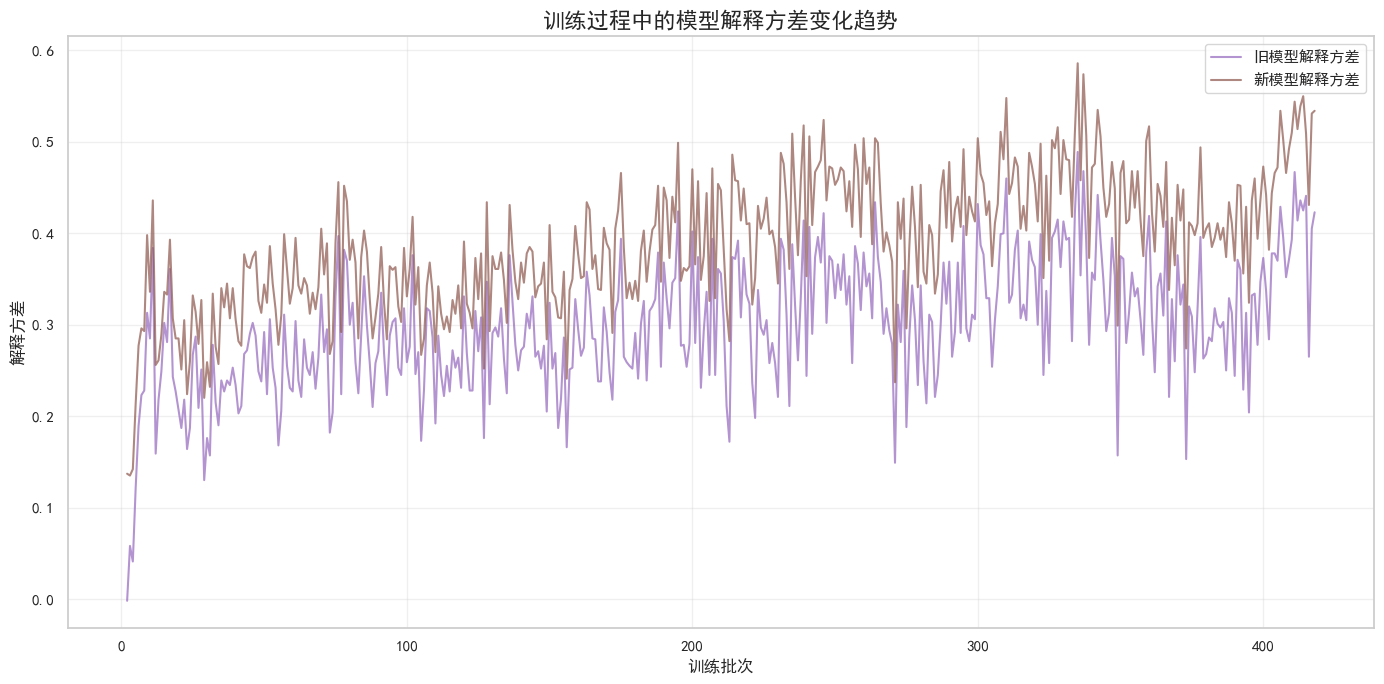

In [9]:
# 解释方差变化趋势
if 'explained_var_old' in train_df.columns and 'explained_var_new' in train_df.columns and len(train_df) > 0:
    plt.figure(figsize=(14, 7))
    
    plt.plot(train_df['batch'], train_df['explained_var_old'], color='tab:purple', marker='', linestyle='-', alpha=0.7, label='旧模型解释方差')
    plt.plot(train_df['batch'], train_df['explained_var_new'], color='tab:brown', marker='', linestyle='-', alpha=0.7, label='新模型解释方差')
    
    plt.xlabel('训练批次')
    plt.ylabel('解释方差')
    plt.title('训练过程中的模型解释方差变化趋势', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('explained_var_trend.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("训练数据不足，无法绘制解释方差变化趋势图")

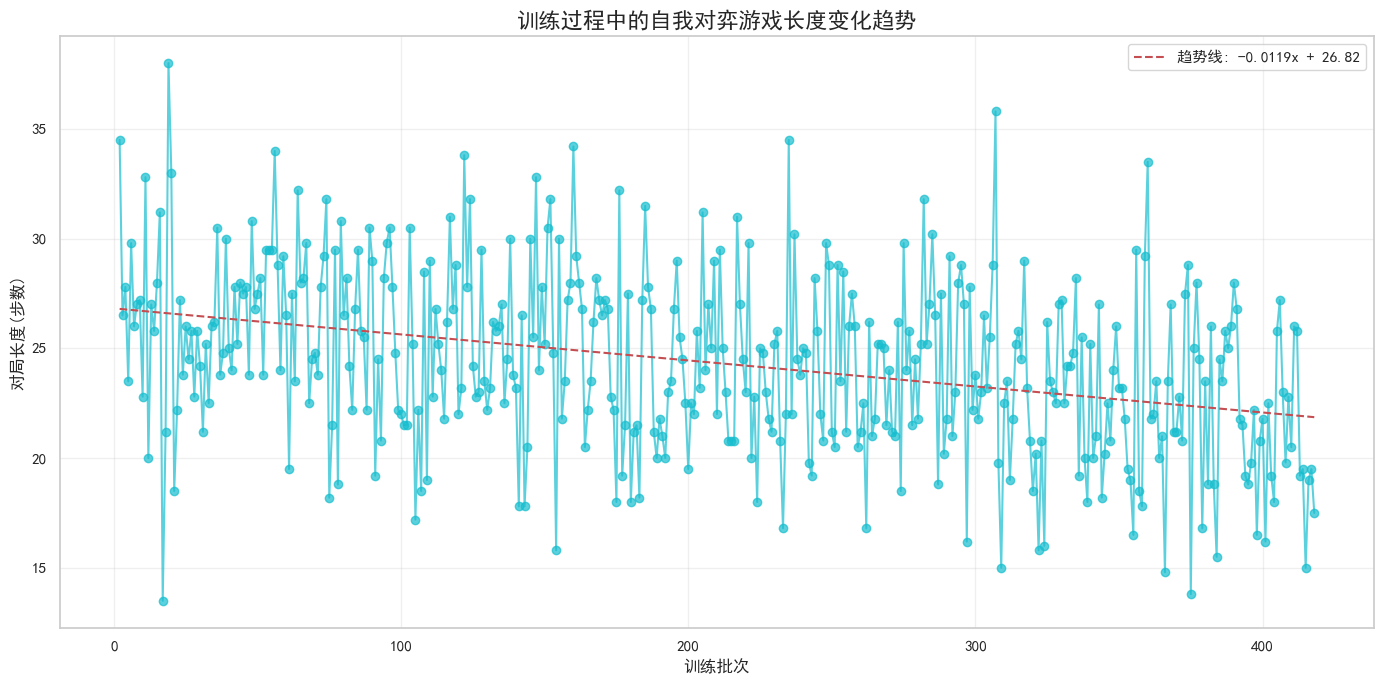

In [10]:
# 自我对弈游戏长度趋势
if 'episode_len' in train_df.columns and len(train_df) > 0:
    plt.figure(figsize=(14, 7))
    
    plt.plot(train_df['batch'], train_df['episode_len'], color='tab:cyan', marker='o', linestyle='-', alpha=0.7)
    
    plt.xlabel('训练批次')
    plt.ylabel('对局长度(步数)')
    plt.title('训练过程中的自我对弈游戏长度变化趋势', fontsize=16)
    plt.grid(True, alpha=0.3)
    
    # 添加趋势线
    if len(train_df) > 1:  # 确保有足够的点拟合趋势线
        z = np.polyfit(train_df['batch'], train_df['episode_len'], 1)
        p = np.poly1d(z)
        plt.plot(train_df['batch'], p(train_df['batch']), "r--", label=f"趋势线: {z[0]:.4f}x + {z[1]:.2f}")
        plt.legend()
    
    plt.tight_layout()
    plt.savefig('episode_length_trend.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("训练数据不足，无法绘制自我对弈游戏长度趋势图")

## 3. 模型评估分析

分析模型定期评估结果，仅包含与纯 MCTS 对手的对局结果，作为总评估结果。

In [11]:
# 删除与非MCTS对手相关的评估结果
eval_df = eval_df.drop(columns=[col for col in eval_df.columns if 'minimax' in col])

# 纯MCTS作为唯一评估结果
eval_df['wins'] = eval_df['pure_mcts_wins']
eval_df['losses'] = eval_df['pure_mcts_losses']
eval_df['draws'] = eval_df['pure_mcts_draws']
eval_df['total_games'] = eval_df['pure_mcts_games']
eval_df['win_ratio'] = eval_df['pure_mcts_win_ratio']

# 确保去掉非必要的列
eval_df = eval_df[['eval_batch', 'wins', 'losses', 'draws', 'total_games', 'win_ratio']]

print(f"处理后共提取 {len(eval_df)} 条评估数据记录 (仅限纯MCTS)")
eval_df.head()

处理后共提取 8 条评估数据记录 (仅限纯MCTS)


,eval_batch,wins,losses,draws,total_games,win_ratio
0,50,31,17,2,50,0.62
1,100,36,10,4,50,0.72
2,150,36,14,0,50,0.72
3,200,37,12,1,50,0.74
4,250,40,10,0,50,0.80


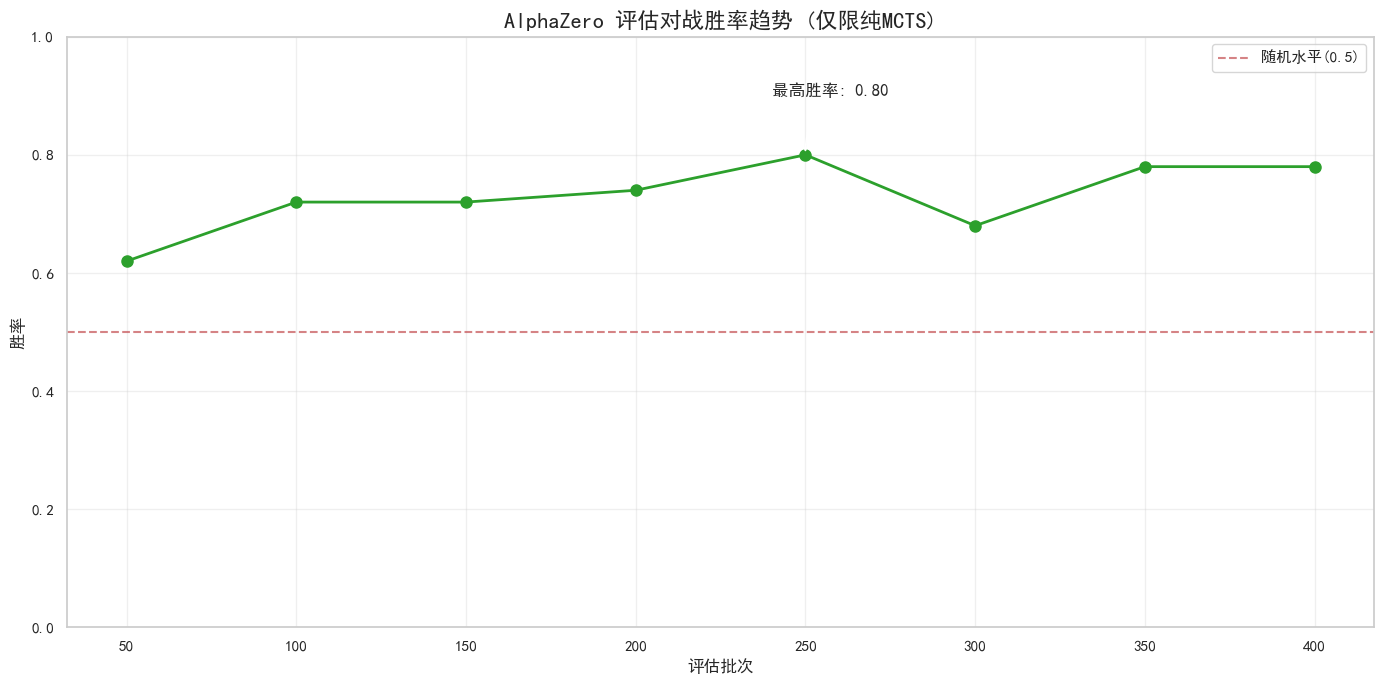

In [12]:
# 胜率变化趋势
if 'win_ratio' in eval_df.columns and len(eval_df) > 0:
    plt.figure(figsize=(14, 7))
    
    plt.plot(eval_df['eval_batch'], eval_df['win_ratio'], color='tab:green', marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='随机水平(0.5)')
    
    plt.xlabel('评估批次')
    plt.ylabel('胜率')
    plt.title('AlphaZero 评估对战胜率趋势 (仅限纯MCTS)', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1)
    plt.legend()
    
    # 添加注释，标记胜率最高点
    if len(eval_df) > 1:
        max_idx = eval_df['win_ratio'].idxmax()
        max_batch = eval_df.loc[max_idx, 'eval_batch']
        max_wr = eval_df.loc[max_idx, 'win_ratio']
        plt.annotate(f'最高胜率: {max_wr:.2f}',
                     xy=(max_batch, max_wr), xycoords='data',
                     xytext=(max_batch-10, max_wr+0.1), textcoords='data',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"), 
                     fontsize=12)
    
    plt.tight_layout()
    plt.savefig('win_ratio_trend_pure_mcts.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("评估数据不足，无法绘制胜率变化趋势图")

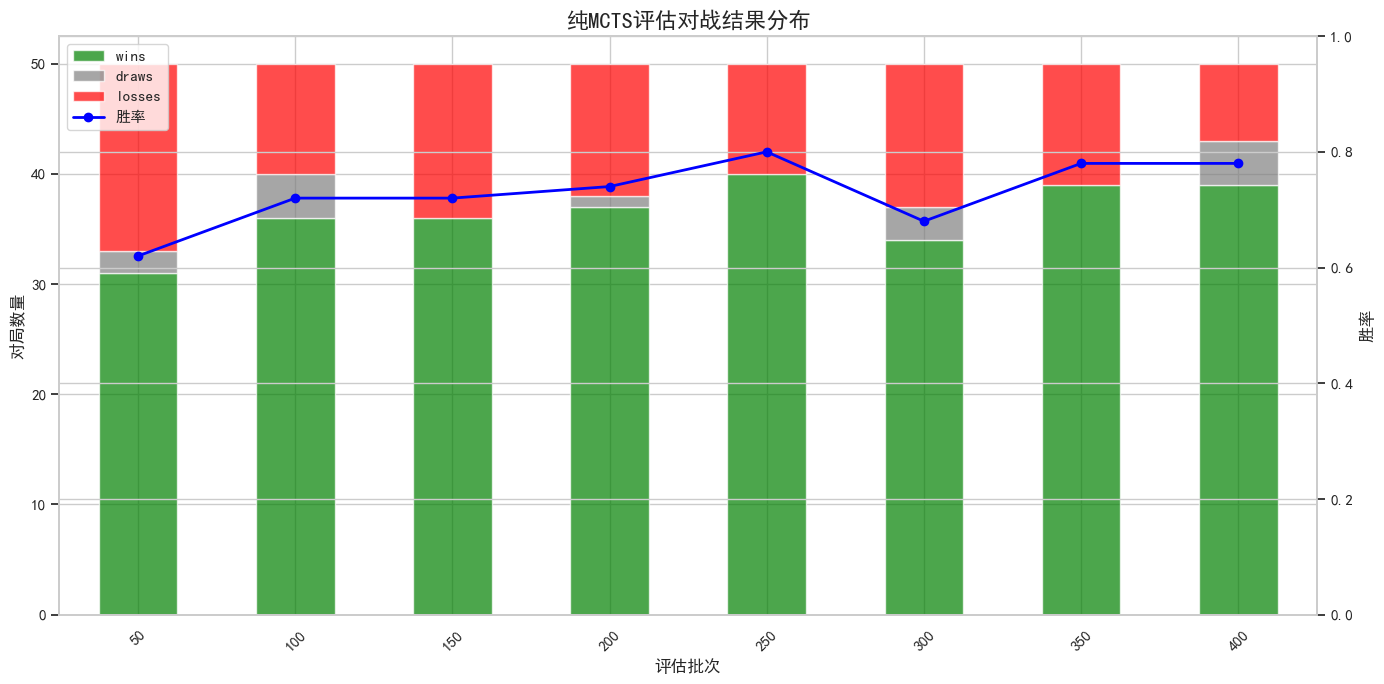

In [13]:
# 胜负平分布堆积图
if 'wins' in eval_df.columns and 'losses' in eval_df.columns and 'draws' in eval_df.columns and len(eval_df) > 0:
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # 堆积柱状图显示胜、负、平的分布
    eval_df.plot(x='eval_batch', y=['wins', 'draws', 'losses'], kind='bar', stacked=True, 
                 color=['green', 'gray', 'red'], ax=ax, alpha=0.7)
    
    # 在同一图上添加胜率线
    if 'win_ratio' in eval_df.columns:
        ax2 = ax.twinx()
        ax2.plot(range(len(eval_df)), eval_df['win_ratio'], color='blue', marker='o', linestyle='-', linewidth=2, label='胜率')
        ax2.set_ylabel('胜率')
        ax2.set_ylim(0, 1)
    
    # 设置图表标题和标签
    ax.set_title('纯MCTS评估对战结果分布', fontsize=16)
    ax.set_xlabel('评估批次')
    ax.set_ylabel('对局数量')
    
    # 设置X轴标签为评估批次
    ax.set_xticklabels(eval_df['eval_batch'], rotation=45)
    
    # 组合两个图例
    lines1, labels1 = ax.get_legend_handles_labels()
    if 'win_ratio' in eval_df.columns:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        ax.legend(loc='upper left')
    
    plt.tight_layout()
    plt.savefig('pure_mcts_evaluation_results_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("评估数据不足，无法绘制胜负平分布堆积图")

## 4. 关键指标相关性分析

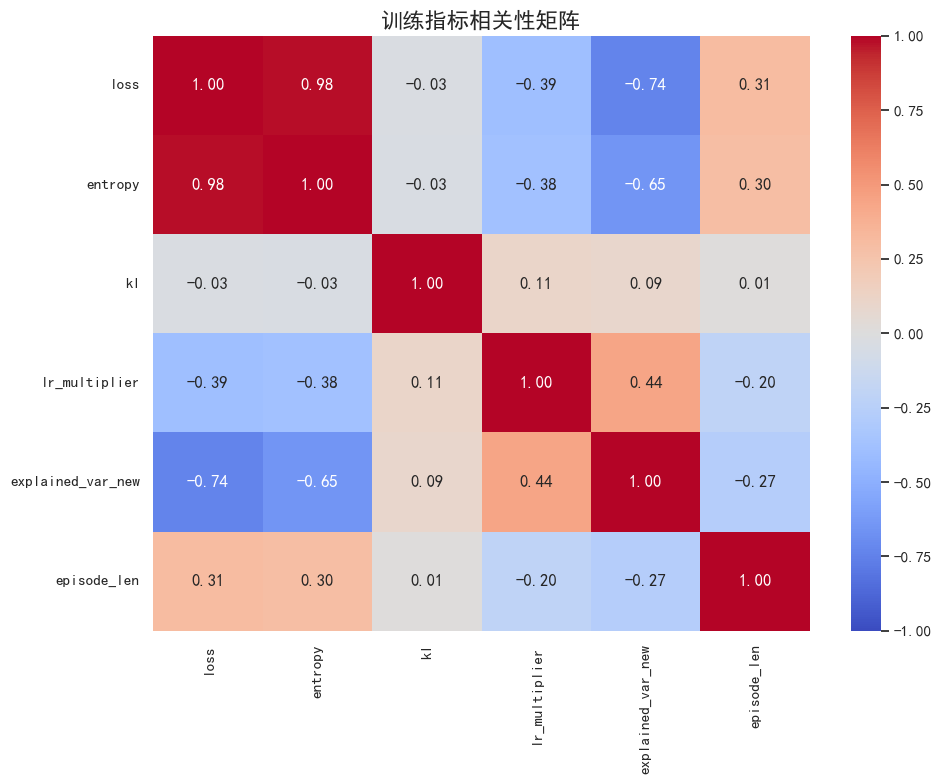

In [14]:
# 训练指标相关性热力图
corr_columns = [col for col in ['loss', 'entropy', 'kl', 'lr_multiplier', 'explained_var_new', 'episode_len'] 
                if col in train_df.columns]

if len(corr_columns) >= 2 and len(train_df) > 1:  # 至少需要两列和两行来计算相关性
    plt.figure(figsize=(10, 8))
    corr_matrix = train_df[corr_columns].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('训练指标相关性矩阵', fontsize=16)
    plt.tight_layout()
    plt.savefig('training_metrics_correlation.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("训练数据不足，无法绘制指标相关性热力图")

In [15]:
# 合并训练和评估数据，分析一些关键指标与胜率的关系
if len(train_df) > 0 and len(eval_df) > 0 and 'win_ratio' in eval_df.columns:
    # 创建合并后的DataFrame用于分析
    merged_data = pd.DataFrame()
    
    # 对于每个评估批次，找到最接近的训练数据点
    for _, eval_row in eval_df.iterrows():
        eval_batch = eval_row['eval_batch']
        
        # 找最接近评估批次的训练数据
        closest_idx = (train_df['batch'] - eval_batch).abs().idxmin()
        if closest_idx is not None:
            closest_train = train_df.loc[closest_idx]
            
            # 合并评估和训练数据
            data = {
                'batch': eval_batch,
                'win_ratio': eval_row['win_ratio']
            }
            
            # 添加可用的训练指标
            for metric in ['loss', 'entropy', 'kl', 'explained_var_new']:
                if metric in closest_train:
                    data[metric] = closest_train[metric]
            
            merged_data = pd.concat([merged_data, pd.DataFrame([data])], ignore_index=True)
    
    # 计算胜率与各指标的相关系数
    correlations = {}
    for column in [col for col in ['loss', 'entropy', 'kl', 'explained_var_new'] if col in merged_data.columns]:
        if len(merged_data) > 1:  # 至少需要2个点来计算相关性
            correlation, p_value = stats.pearsonr(merged_data['win_ratio'], merged_data[column])
            correlations[column] = (correlation, p_value)
    
    # 显示结果
    if correlations:
        for metric, (corr, p_val) in correlations.items():
            significance = "显著" if p_val < 0.05 else "不显著"
            print(f"胜率与{metric}的相关性: {corr:.4f} (p={p_val:.4f}, {significance})")
    else:
        print("无法计算胜率与训练指标的相关性，数据不足或缺少关键指标")
else:
    print("训练或评估数据不足，无法分析关键指标与胜率的关系")

胜率与loss的相关性: -0.7352 (p=0.0377, 显著)
胜率与entropy的相关性: -0.7667 (p=0.0265, 显著)
胜率与kl的相关性: -0.4131 (p=0.3091, 不显著)
胜率与explained_var_new的相关性: 0.4870 (p=0.2209, 不显著)


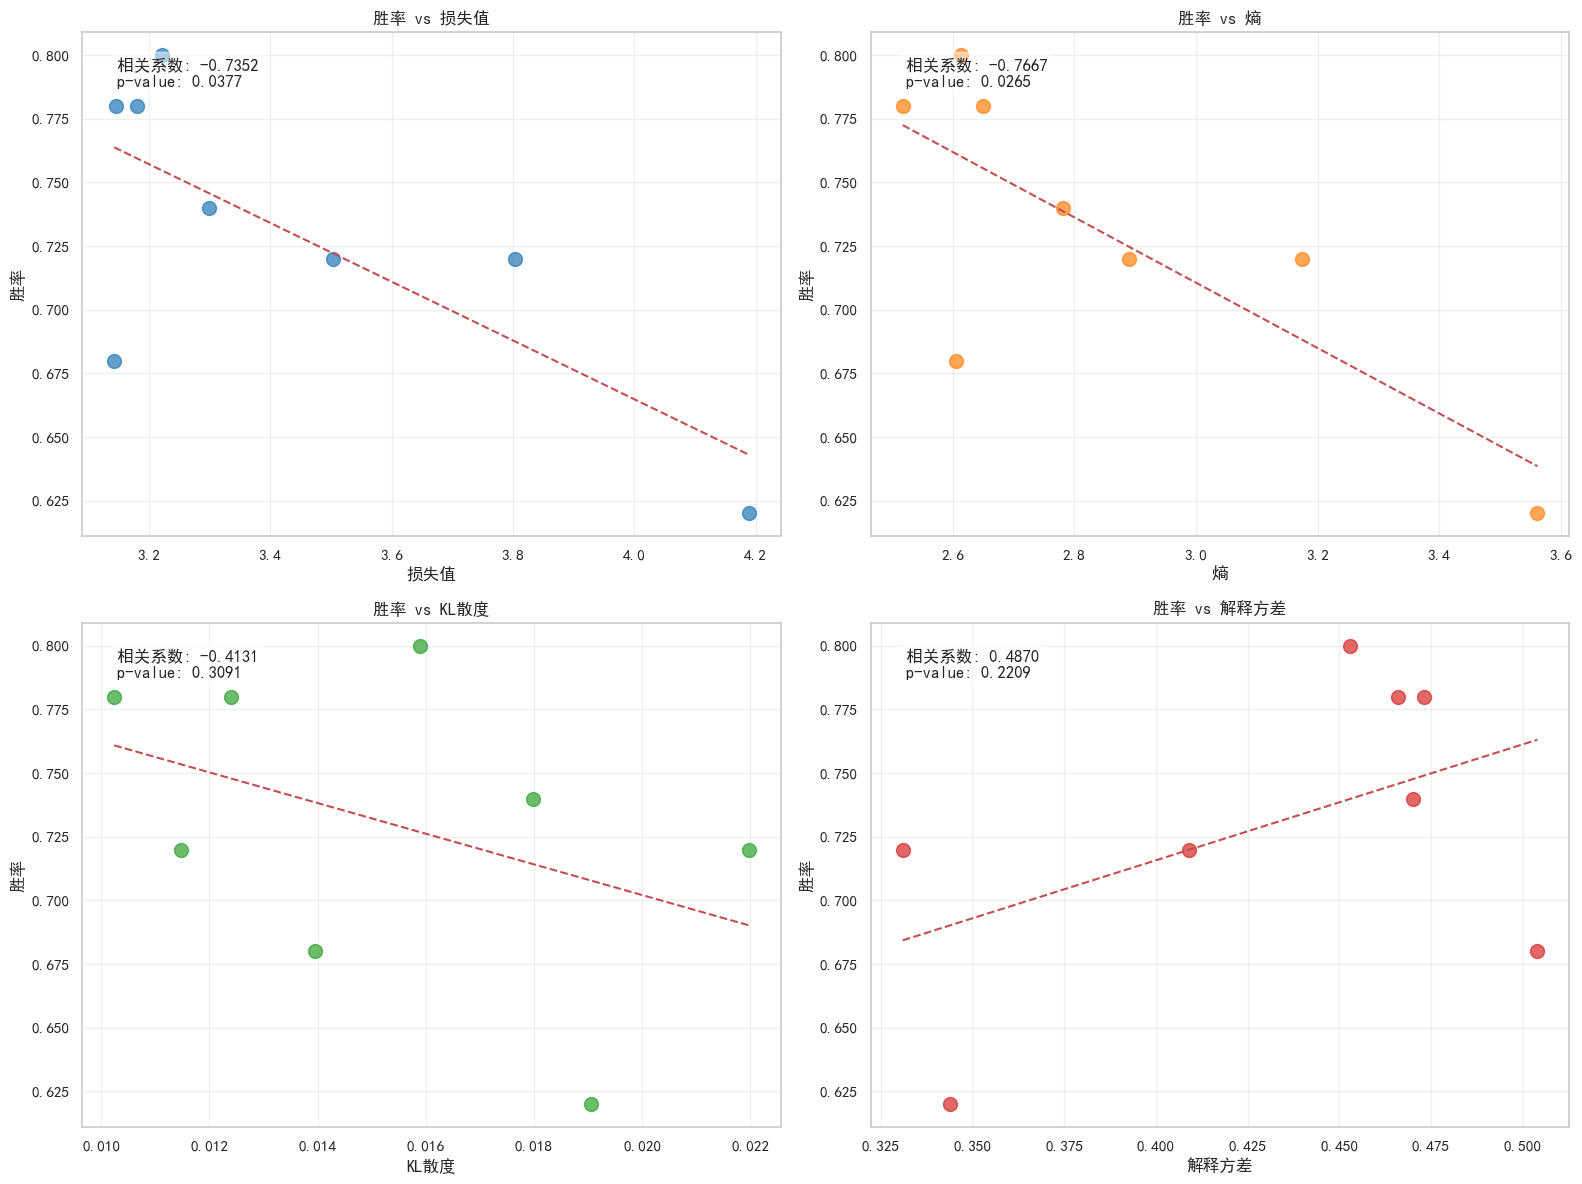

In [16]:
# 胜率与关键指标散点图
if 'merged_data' in locals() and len(merged_data) > 1 and 'win_ratio' in merged_data.columns:
    metrics = [col for col in ['loss', 'entropy', 'kl', 'explained_var_new'] if col in merged_data.columns]
    
    if metrics:  # 确保有指标数据
        fig, axes = plt.subplots(min(2, len(metrics)), min(2, (len(metrics) + 1) // 2), figsize=(16, 12))
        # 确保axes是二维数组
        if len(metrics) == 1:
            axes = np.array([[axes]])
        elif len(metrics) <= 2:
            axes = np.array([axes])
        axes = axes.flatten()
        
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        titles = {'loss': '损失值', 'entropy': '熵', 'kl': 'KL散度', 'explained_var_new': '解释方差'}
        
        for i, metric in enumerate(metrics):
            if i < len(axes):  # 确保有足够的子图
                axes[i].scatter(merged_data[metric], merged_data['win_ratio'], color=colors[i % len(colors)], alpha=0.7, s=100)
                
                # 添加趋势线
                z = np.polyfit(merged_data[metric], merged_data['win_ratio'], 1)
                p = np.poly1d(z)
                x_range = np.linspace(min(merged_data[metric]), max(merged_data[metric]), 100)
                axes[i].plot(x_range, p(x_range), 'r--')
                
                # 显示相关系数
                if metric in correlations:
                    corr, p_val = correlations[metric]
                    axes[i].text(0.05, 0.95, f"相关系数: {corr:.4f}\np-value: {p_val:.4f}", 
                                transform=axes[i].transAxes, fontsize=12,
                                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
                
                axes[i].set_xlabel(titles.get(metric, metric))
                axes[i].set_ylabel('胜率')
                axes[i].set_title(f'胜率 vs {titles.get(metric, metric)}')
                axes[i].grid(True, alpha=0.3)
        
        # 隐藏未使用的子图
        for i in range(len(metrics), len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.savefig('win_ratio_vs_metrics_pure_mcts.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("没有足够的指标数据来绘制散点图")
else:
    print("数据不足，无法绘制胜率与关键指标的散点图")

## 5. 训练进度与稳定性分析

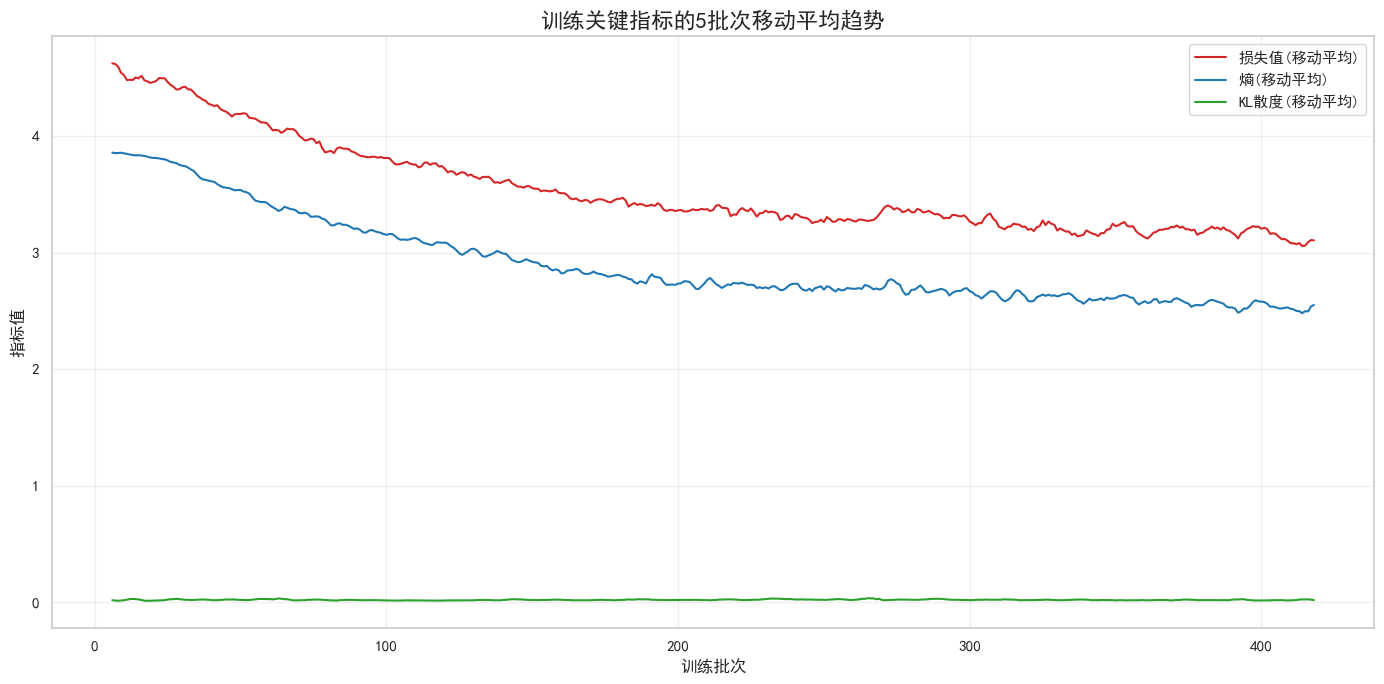

In [17]:
# 计算关键指标的移动平均，用于观察趋势更平滑的变化
window_size = 5  # 移动平均窗口大小，对于较少的数据使用更小的窗口

if len(train_df) > window_size:
    # 选择要计算移动平均的指标
    ma_metrics = [col for col in ['loss', 'entropy', 'kl'] if col in train_df.columns]
    
    if ma_metrics:  # 确保有指标数据
        # 计算移动平均
        for metric in ma_metrics:
            train_df[f'{metric}_ma'] = train_df[metric].rolling(window=window_size).mean()
        
        plt.figure(figsize=(14, 7))
        
        colors = {'loss_ma': 'tab:red', 'entropy_ma': 'tab:blue', 'kl_ma': 'tab:green'}
        labels = {'loss_ma': '损失值(移动平均)', 'entropy_ma': '熵(移动平均)', 'kl_ma': 'KL散度(移动平均)'}
        
        for metric in ma_metrics:
            ma_col = f'{metric}_ma'
            plt.plot(train_df['batch'][window_size-1:], train_df[ma_col][window_size-1:], 
                     color=colors.get(ma_col, 'black'), label=labels.get(ma_col, ma_col))
        
        plt.xlabel('训练批次')
        plt.ylabel('指标值')
        plt.title(f'训练关键指标的{window_size}批次移动平均趋势', fontsize=16)
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('metrics_moving_average_pure_mcts.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("没有足够的指标数据来计算移动平均")
else:
    print(f"训练数据点不足{window_size}个，无法计算移动平均。")

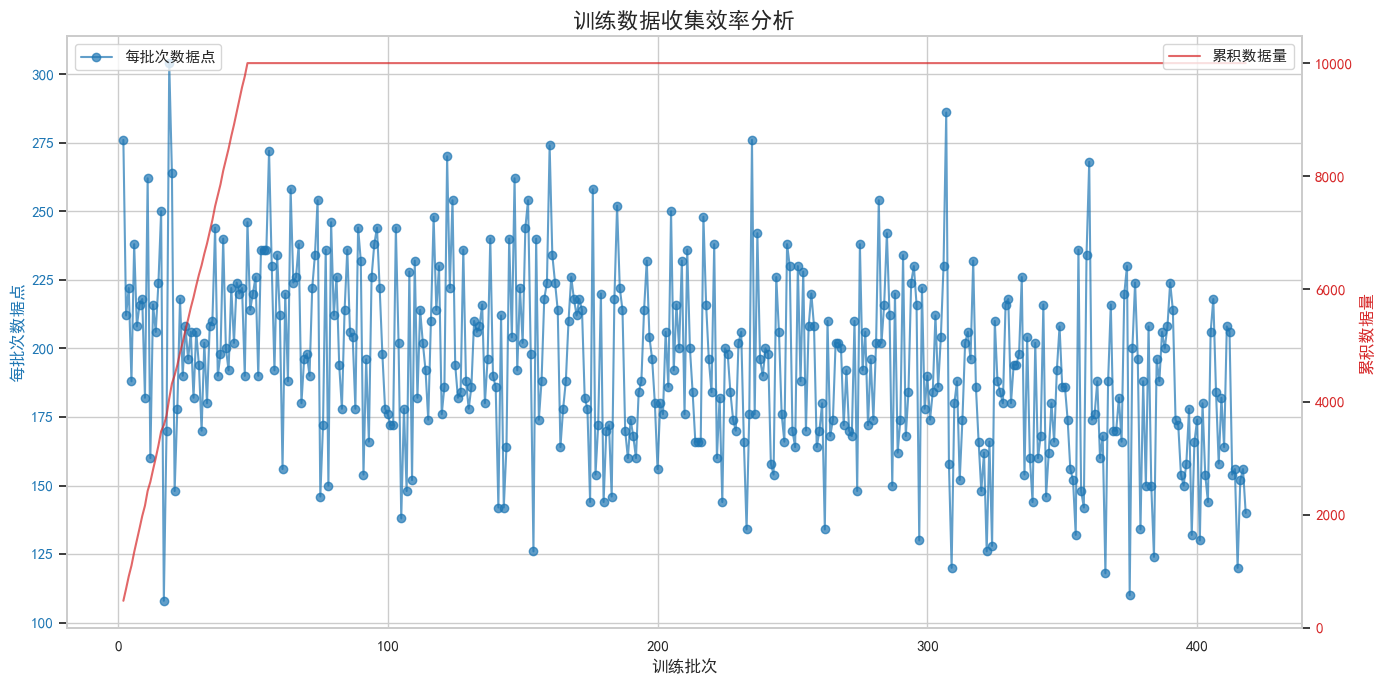

In [18]:
# 数据收集与训练效率分析
if 'data_points' in train_df.columns and 'total_data' in train_df.columns and len(train_df) > 1:
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # 每批次收集的数据点
    color = 'tab:blue'
    ax1.set_xlabel('训练批次')
    ax1.set_ylabel('每批次数据点', color=color)
    ax1.plot(train_df['batch'], train_df['data_points'], color=color, marker='o', alpha=0.7)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # 数据总量
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('累积数据量', color=color)
    ax2.plot(train_df['batch'], train_df['total_data'], color=color, linestyle='-', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)
    
    plt.title('训练数据收集效率分析', fontsize=16)
    plt.grid(False)
    
    # 添加图例
    ax1.legend(['每批次数据点'], loc='upper left')
    ax2.legend(['累积数据量'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('data_collection_efficiency.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("训练数据不足，无法分析数据收集效率")

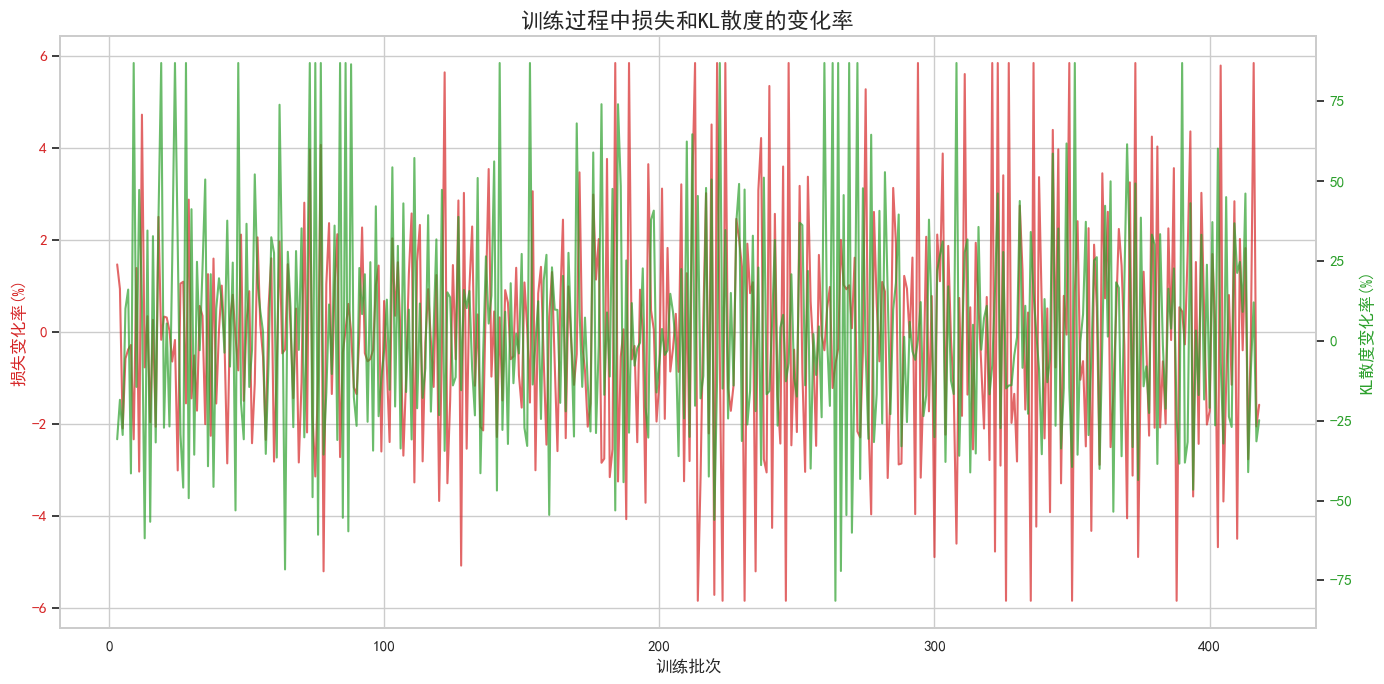

损失值变化率标准差: 2.55%
KL散度变化率标准差: 35.70%
损失值平均绝对变化率: 2.01%
KL散度平均绝对变化率: 28.99%


In [19]:
# 计算KL散度和损失的变化率，分析训练稳定性
if len(train_df) > 1 and 'loss' in train_df.columns and 'kl' in train_df.columns:
    train_df['loss_change'] = train_df['loss'].pct_change() * 100  # 百分比变化
    train_df['kl_change'] = train_df['kl'].pct_change() * 100

    # 去掉第一行（因为变化率计算会产生NaN）和过大的值
    change_df = train_df.iloc[1:].copy()
    # 限制变化率范围，便于可视化
    if len(change_df) > 0:
        loss_upper = np.percentile(change_df['loss_change'].abs(), 95) if len(change_df) > 20 else change_df['loss_change'].abs().max()
        kl_upper = np.percentile(change_df['kl_change'].abs(), 95) if len(change_df) > 20 else change_df['kl_change'].abs().max()
        change_df.loc[change_df['loss_change'] > loss_upper, 'loss_change'] = loss_upper
        change_df.loc[change_df['loss_change'] < -loss_upper, 'loss_change'] = -loss_upper
        change_df.loc[change_df['kl_change'] > kl_upper, 'kl_change'] = kl_upper
        change_df.loc[change_df['kl_change'] < -kl_upper, 'kl_change'] = -kl_upper

        fig, ax1 = plt.subplots(figsize=(14, 7))

        color = 'tab:red'
        ax1.set_xlabel('训练批次')
        ax1.set_ylabel('损失变化率(%)', color=color)
        ax1.plot(change_df['batch'], change_df['loss_change'], color=color, marker='', linestyle='-', alpha=0.7)
        ax1.tick_params(axis='y', labelcolor=color)

        # 创建第二个Y轴
        ax2 = ax1.twinx()  
        color = 'tab:green'
        ax2.set_ylabel('KL散度变化率(%)', color=color)  
        ax2.plot(change_df['batch'], change_df['kl_change'], color=color, marker='', linestyle='-', alpha=0.7)
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title('训练过程中损失和KL散度的变化率', fontsize=16)
        plt.grid(False)

        plt.tight_layout()
        plt.savefig('metrics_change_rate.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 计算稳定性指标：变化率的标准差和平均绝对值
        loss_stability = change_df['loss_change'].std()
        kl_stability = change_df['kl_change'].std()
        loss_avg_change = change_df['loss_change'].abs().mean()
        kl_avg_change = change_df['kl_change'].abs().mean()
        
        print(f"损失值变化率标准差: {loss_stability:.2f}%")
        print(f"KL散度变化率标准差: {kl_stability:.2f}%")
        print(f"损失值平均绝对变化率: {loss_avg_change:.2f}%")
        print(f"KL散度平均绝对变化率: {kl_avg_change:.2f}%")
    else:
        print("计算变化率后数据不足，无法进行稳定性分析。")
else:
    print("训练数据点不足，无法计算变化率。")